In [9]:
# Experiment 3 KD with a smaller model as student

In [1]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler, QuantileTransformer 

from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Knowledge distillation 
# Modified from source: https://keras.io/examples/vision/knowledge_distillation/

import Distiller

In [4]:
# Load the saved dataset
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
california_housing_data_train = pd.read_csv('Data/california_housing_train.txt')
california_housing_data_test = pd.read_csv('Data/california_housing_test.txt')

# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set
california_housing_data_train = california_housing_data_train[california_housing_data_train['MedHouseVal'] < 5]  


In [5]:
# Set up the datasets
x_train = california_housing_data_train.iloc[:,0:7].to_numpy()
y_train = california_housing_data_train.iloc[:,-1].to_numpy()

x_test = california_housing_data_test.iloc[:,0:7].to_numpy()
y_test = california_housing_data_test.iloc[:,-1].to_numpy()

In [6]:
# Build the student model

def buildStudentModel():
    model = models.Sequential()    
    model.add(layers.Dense(32, activation='relu'))
        
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))    
    
    return model

In [7]:
# Construct/load models

teacher_model = tf.keras.models.load_model('MlpTeacherModel/MlpTeacherModel')

# Perform the 10 fold cross validation
number_of_folds = 10

skf = KFold(n_splits=number_of_folds)

In [8]:
# Haperparameter used in the experiment
number_of_epochs = 100

train_val_results_with_distillation = []
train_val_results_without_distillation = []

test_results_with_distillation = []
test_results_without_distillation = []

for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {i}")
    
    studnet_model = buildStudentModel()
    studnet_model_without_distillation = keras.models.clone_model(studnet_model)
    
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['mse', 'mae', 'mape'],
        student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
        distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
        alpha=0.1,
        temperature=10        
    )
    # Distill teacher to student
    history = distiller.fit(
        x_train_fold, 
        y_train_fold, 
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_with_distillation.append(history.history)
    
    # Train and evaluate the student model without distillation
    studnet_model_without_distillation.compile(
        optimizer=keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=['mse', 'mae', 'mape'],
    )

    # Train and evaluate student trained from scratch.
    history = studnet_model_without_distillation.fit(
        x_train_fold, 
        y_train_fold,
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_without_distillation.append(history.history)
    
print('Training done')

Fold 0
Epoch 1/100
443/443 [==============================] - 2s 2ms/step - mse: 1790.0743 - mae: 10.5533 - mape: 699.1052 - student_loss: 10.5170 - distillation_loss: 1781.7470 - val_mse: 6.1470 - val_mae: 1.8284 - val_mape: 124.0408 - val_student_loss: 1.8504
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 4.6679 - mae: 1.5740 - mape: 104.6904 - student_loss: 1.5709 - distillation_loss: 4.3153 - val_mse: 2.7282 - val_mae: 1.2109 - val_mape: 81.7678 - val_student_loss: 1.4315
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.8533 - mae: 0.9780 - mape: 65.3099 - student_loss: 0.9761 - distillation_loss: 1.4649 - val_mse: 1.0376 - val_mae: 0.7351 - val_mape: 48.0501 - val_student_loss: 0.9739
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9208 - mae: 0.7093 - mape: 47.9839 - student_loss: 0.7076 - distillation_loss: 0.5068 - val_mse: 0.7773 - val_mae: 0.6683 - val_mape: 47.5450 - val_student_loss: 0.8814
Ep

443/443 [==============================] - 1s 2ms/step - mse: 0.6104 - mae: 0.5865 - mape: 38.5947 - student_loss: 0.5861 - distillation_loss: 0.1870 - val_mse: 0.5121 - val_mae: 0.5406 - val_mape: 34.7059 - val_student_loss: 0.6036
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5176 - mae: 0.5484 - mape: 35.9400 - student_loss: 0.5477 - distillation_loss: 0.0980 - val_mse: 0.5228 - val_mae: 0.5376 - val_mape: 32.7387 - val_student_loss: 0.6082
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5401 - mae: 0.5589 - mape: 36.3880 - student_loss: 0.5602 - distillation_loss: 0.1170 - val_mse: 0.5190 - val_mae: 0.5359 - val_mape: 34.3341 - val_student_loss: 0.5957
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 5.8288 - mae: 1.0793 - mape: 70.5834 - student_loss: 1.0765 - distillation_loss: 5.3903 - val_mse: 0.6162 - val_mae: 0.5402 - val_mape: 33.1552 - val_student_loss: 0.6579
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.7183 - mae: 0.6179 - mape: 40.0085 - student_loss: 0.6173 - distillation_loss: 0.3092 - val_mse: 0.5231 - val_mae: 0.5484 - val_mape: 37.6434 - val_student_loss: 0.6573
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 1.8247 - mae: 0.7630 - mape: 49.9228 - student_loss: 0.7625 - distillation_loss: 1.4120 - val_mse: 0.5001 - val_mae: 0.5534 - val_mape: 37.9853 - val_student_loss: 0.6497
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5865 - mae: 0.5738 - mape: 37.2767 - student_loss: 0.5744 - distillation_loss: 0.1715 - val_mse: 0.4862 - val_mae: 0.5213 - val_mape: 32.1542 - val_student_loss: 0.5617
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 1.6251 - mae: 0.7899 - mape: 50.8834 - student_loss: 0.7877 - distillation_loss: 1.2217 - val_mse: 0.4886 - val_mae: 0.5282 - val_mape: 32.9575 - val_student_loss: 0.6100
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 1.5742 - mae: 0.8023 - mape: 52.1822 - student_loss: 0.8021 - distillation_loss: 1.1467 - val_mse: 0.5497 - val_mae: 0.5696 - val_mape: 38.3119 - val_student_loss: 0.7425
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 2.5770 - mse: 62.2673 - mae: 2.5770 - mape: 167.0876 - val_loss: 1.0334 - val_mse: 1.7533 - val_mae: 1.0334 - val_mape: 83.2010
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3191 - mse: 3.9197 - mae: 1.3191 - mape: 86.3267 - val_loss: 0.6299 - val_mse: 0.9211 - val_mae: 0.6299 - val_mape: 36.0363
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0443 - mse: 2.3121 - mae: 1.0443 - mape: 68.2727 - val_loss: 1.1132 - val_mse: 1.9727 - val_mae: 1.1132 - val_mape: 88.0023
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 1.4313 - mse: 4.6390 - mae: 1.4313 - mape: 92.9934 - val_loss: 0.6466 - val_mse: 0.7352

443/443 [==============================] - 1s 2ms/step - loss: 0.6162 - mse: 0.7244 - mae: 0.6162 - mape: 38.3764 - val_loss: 0.5184 - val_mse: 0.6106 - val_mae: 0.5184 - val_mape: 30.6470
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6360 - mse: 0.8157 - mae: 0.6360 - mape: 39.6905 - val_loss: 0.5837 - val_mse: 0.5886 - val_mae: 0.5837 - val_mape: 41.1678
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6049 - mse: 0.6995 - mae: 0.6049 - mape: 37.2191 - val_loss: 0.7883 - val_mse: 1.1738 - val_mae: 0.7883 - val_mape: 60.6891
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6080 - mse: 0.8102 - mae: 0.6080 - mape: 37.4029 - val_loss: 0.7354 - val_mse: 0.7889 - val_mae: 0.7354 - val_mape: 55.4055
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6123 - mse: 0.7495 - mae: 0.6123 - mape: 37.8638 - val_loss: 0.6754 - val_mse: 0.7374 - val_mae: 0.6754 - val_mape: 51.2952
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5061 - mse: 0.4639 - mae: 0.5061 - mape: 30.9212 - val_loss: 0.5010 - val_mse: 0.4401 - val_mae: 0.5010 - val_mape: 30.2466
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4975 - mse: 0.4496 - mae: 0.4975 - mape: 30.2287 - val_loss: 0.4635 - val_mse: 0.3980 - val_mae: 0.4635 - val_mape: 27.3915
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4933 - mse: 0.4430 - mae: 0.4933 - mape: 30.0395 - val_loss: 0.4816 - val_mse: 0.4324 - val_mae: 0.4816 - val_mape: 27.9334
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5051 - mse: 0.4607 - mae: 0.5051 - mape: 30.8459 - val_loss: 0.5040 - val_mse: 0.4110 - val_mae: 0.5040 - val_mape: 34.9974
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5034 - mse: 0.4591 - mae: 0.5034 - mape: 30.7270 - val_loss: 0.5041 - val_mse: 0.4187 - val_mae: 0.5041 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5132 - mae: 0.5451 - mape: 35.6816 - student_loss: 0.5445 - distillation_loss: 0.0967 - val_mse: 0.5024 - val_mae: 0.5526 - val_mape: 36.4743 - val_student_loss: 0.4024
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5147 - mae: 0.5459 - mape: 35.5952 - student_loss: 0.5451 - distillation_loss: 0.1011 - val_mse: 0.5271 - val_mae: 0.5449 - val_mape: 31.8836 - val_student_loss: 0.3563
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5372 - mae: 0.5553 - mape: 36.1414 - student_loss: 0.5563 - distillation_loss: 0.1202 - val_mse: 0.7663 - val_mae: 0.6771 - val_mape: 48.5557 - val_student_loss: 0.5756
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5313 - mae: 0.5549 - mape: 36.0028 - student_loss: 0.5544 - distillation_loss: 0.1149 - val_mse: 0.4963 - val_mae: 0.5381 - val_mape: 33.7743 - val_student_loss: 0.3929
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 1.5886 - mae: 0.8657 - mape: 56.3325 - student_loss: 0.8645 - distillation_loss: 1.1716 - val_mse: 0.5336 - val_mae: 0.5480 - val_mape: 32.3370 - val_student_loss: 0.4450
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 1.8119 - mae: 0.8673 - mape: 56.6619 - student_loss: 0.8667 - distillation_loss: 1.4021 - val_mse: 0.4832 - val_mae: 0.5332 - val_mape: 34.9125 - val_student_loss: 0.4172
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 1.2556 - mae: 0.7281 - mape: 47.0093 - student_loss: 0.7297 - distillation_loss: 0.8508 - val_mse: 0.4902 - val_mae: 0.5438 - val_mape: 36.1860 - val_student_loss: 0.4619
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8907 - mae: 0.6591 - mape: 42.7984 - student_loss: 0.6584 - distillation_loss: 0.4656 - val_mse: 0.4768 - val_mae: 0.5255 - val_mape: 33.1070 - val_student_loss: 0.4214
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4933 - mae: 0.5314 - mape: 34.3317 - student_loss: 0.5333 - distillation_loss: 0.0883 - val_mse: 0.6572 - val_mae: 0.5932 - val_mape: 31.4105 - val_student_loss: 0.2588
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8496 - mae: 0.6510 - mape: 42.2450 - student_loss: 0.6507 - distillation_loss: 0.4394 - val_mse: 0.4861 - val_mae: 0.5268 - val_mape: 32.4059 - val_student_loss: 0.3325
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6620 - mae: 0.6047 - mape: 39.1401 - student_loss: 0.6039 - distillation_loss: 0.2466 - val_mse: 0.4818 - val_mae: 0.5175 - val_mape: 30.7323 - val_student_loss: 0.3329
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 1.6915 - mae: 0.7847 - mape: 51.4912 - student_loss: 0.7837 - distillation_loss: 1.2869 - val_mse: 0.4774 - val_mae: 0.5311 - val_mape: 34.5989 - val_student_loss: 0.3795
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7965 - mse: 1.2584 - mae: 0.7965 - mape: 50.7872 - val_loss: 1.2053 - val_mse: 3.2129 - val_mae: 1.2053 - val_mape: 66.2821
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6852 - mse: 0.8571 - mae: 0.6852 - mape: 42.7978 - val_loss: 0.6819 - val_mse: 0.7472 - val_mae: 0.6819 - val_mape: 49.9755
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7245 - mse: 1.0437 - mae: 0.7245 - mape: 45.4434 - val_loss: 0.6148 - val_mse: 0.7060 - val_mae: 0.6148 - val_mape: 32.8445
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6693 - mse: 0.8832 - mae: 0.6693 - mape: 41.9857 - val_loss: 1.2345 - val_mse: 2.9373 - val_mae: 1.2345 - val_mape: 89.6690
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7805 - mse: 1.1808 - mae: 0.7805 - mape: 49.4513 - val_loss: 0.5247 - val_mse: 0.4936 - val_mae: 0.5247 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5715 - mse: 0.5986 - mae: 0.5715 - mape: 35.2714 - val_loss: 0.7279 - val_mse: 0.9706 - val_mae: 0.7279 - val_mape: 37.4317
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6012 - mse: 0.6783 - mae: 0.6012 - mape: 37.5269 - val_loss: 0.7867 - val_mse: 1.2207 - val_mae: 0.7867 - val_mape: 54.6045
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6029 - mse: 0.7370 - mae: 0.6029 - mape: 37.5115 - val_loss: 0.4953 - val_mse: 0.4642 - val_mae: 0.4953 - val_mape: 30.4544
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5605 - mse: 0.5967 - mae: 0.5605 - mape: 34.4463 - val_loss: 0.5518 - val_mse: 0.5201 - val_mae: 0.5518 - val_mape: 37.9980
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5691 - mse: 0.6033 - mae: 0.5691 - mape: 35.1704 - val_loss: 0.7117 - val_mse: 0.8901 - val_mae: 0.7117 - val_mape: 51.2011
Epo

443/443 [==============================] - 1s 3ms/step - mse: 7749.7573 - mae: 19.5558 - mape: 1312.5024 - student_loss: 19.4869 - distillation_loss: 7717.6638 - val_mse: 9.2287 - val_mae: 2.4782 - val_mape: 183.3668 - val_student_loss: 1.2260
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 5.8961 - mae: 1.9569 - mape: 140.0411 - student_loss: 1.9540 - distillation_loss: 5.6220 - val_mse: 3.6718 - val_mae: 1.5745 - val_mape: 114.0266 - val_student_loss: 1.2766
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 3.2361 - mae: 1.4384 - mape: 99.1216 - student_loss: 1.4371 - distillation_loss: 2.8535 - val_mse: 4.1144 - val_mae: 1.6026 - val_mape: 123.4936 - val_student_loss: 0.9678
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 2.5332 - mae: 1.2427 - mape: 83.4574 - student_loss: 1.2404 - distillation_loss: 2.1313 - val_mse: 1.9092 - val_mae: 1.1037 - val_mape: 75.8219 - val_student_loss: 1.2447
Epoch 5/100
443/44

443/443 [==============================] - 1s 2ms/step - mse: 0.9641 - mae: 0.6984 - mape: 45.4759 - student_loss: 0.6976 - distillation_loss: 0.5425 - val_mse: 0.5929 - val_mae: 0.5587 - val_mape: 31.7452 - val_student_loss: 0.5352
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 2.8228 - mae: 0.8458 - mape: 55.2899 - student_loss: 0.8451 - distillation_loss: 2.4185 - val_mse: 0.5150 - val_mae: 0.5444 - val_mape: 36.1235 - val_student_loss: 0.5530
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 4.5615 - mae: 1.0866 - mape: 70.7709 - student_loss: 1.0831 - distillation_loss: 4.1166 - val_mse: 0.5401 - val_mae: 0.5734 - val_mape: 39.7390 - val_student_loss: 0.5472
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 5.5931 - mae: 1.0648 - mape: 69.5787 - student_loss: 1.0651 - distillation_loss: 5.1640 - val_mse: 51.5726 - val_mae: 5.3493 - val_mape: 344.4455 - val_student_loss: 4.1307
Epoch 38/100
443/443 [=====

443/443 [==============================] - 1s 2ms/step - mse: 10.1360 - mae: 1.4045 - mape: 91.6426 - student_loss: 1.4007 - distillation_loss: 9.6936 - val_mse: 0.4887 - val_mae: 0.5293 - val_mape: 34.8901 - val_student_loss: 0.4932
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5293 - mae: 0.5535 - mape: 35.8424 - student_loss: 0.5533 - distillation_loss: 0.1150 - val_mse: 0.5129 - val_mae: 0.5261 - val_mape: 32.0515 - val_student_loss: 0.4978
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7227 - mae: 0.6388 - mape: 41.1160 - student_loss: 0.6408 - distillation_loss: 0.3102 - val_mse: 0.5596 - val_mae: 0.5373 - val_mape: 30.1273 - val_student_loss: 0.4930
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 7.7613 - mae: 1.3751 - mape: 90.6419 - student_loss: 1.3733 - distillation_loss: 7.3572 - val_mse: 0.9705 - val_mae: 0.8105 - val_mape: 60.7983 - val_student_loss: 0.6406
Epoch 71/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 1.9915 - mae: 0.9429 - mape: 61.7998 - student_loss: 0.9422 - distillation_loss: 1.5817 - val_mse: 1.4520 - val_mae: 0.9477 - val_mape: 71.2528 - val_student_loss: 0.6770
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0832 - mse: 3.6361 - mae: 1.0832 - mape: 71.3475 - val_loss: 0.7339 - val_mse: 0.8722 - val_mae: 0.7339 - val_mape: 56.5943
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8523 - mse: 1.8789 - mae: 0.8523 - mape: 55.1137 - val_loss: 1.1872 - val_mse: 2.3536 - val_mae: 1.1872 - val_mape: 92.4482
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7964 - mse: 1.5533 - mae: 0.7964 - mape: 51.7034 - val_loss: 1.2529 - val_mse: 2.6193 - val_mae: 1.2529 - val_mape: 70.5086
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9889 - mse: 2.0541 - mae: 0.9889 - mape: 63.7706 - val_loss: 1.0597 - val_mse: 1.8558 -

443/443 [==============================] - 1s 2ms/step - loss: 0.6176 - mse: 0.7062 - mae: 0.6176 - mape: 38.3462 - val_loss: 0.5037 - val_mse: 0.4707 - val_mae: 0.5037 - val_mape: 31.1185
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6009 - mse: 0.7367 - mae: 0.6009 - mape: 37.0677 - val_loss: 0.6368 - val_mse: 0.6540 - val_mae: 0.6368 - val_mape: 45.7532
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6120 - mse: 0.7238 - mae: 0.6120 - mape: 37.9729 - val_loss: 1.0977 - val_mse: 1.9736 - val_mae: 1.0977 - val_mape: 82.5487
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6261 - mse: 0.7945 - mae: 0.6261 - mape: 38.9801 - val_loss: 0.6557 - val_mse: 0.6652 - val_mae: 0.6557 - val_mape: 47.9750
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6858 - mse: 0.9630 - mae: 0.6858 - mape: 42.9083 - val_loss: 0.5814 - val_mse: 0.6478 - val_mae: 0.5814 - val_mape: 31.8027
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5648 - mse: 0.5882 - mae: 0.5648 - mape: 34.8322 - val_loss: 0.5012 - val_mse: 0.4526 - val_mae: 0.5012 - val_mape: 31.9306
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5291 - mse: 0.5974 - mae: 0.5291 - mape: 32.5234 - val_loss: 0.7039 - val_mse: 0.8887 - val_mae: 0.7039 - val_mape: 38.8911
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5542 - mse: 0.5709 - mae: 0.5542 - mape: 34.1898 - val_loss: 0.5135 - val_mse: 0.4761 - val_mae: 0.5135 - val_mape: 33.5120
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5591 - mse: 0.7216 - mae: 0.5591 - mape: 34.5029 - val_loss: 0.5363 - val_mse: 0.5613 - val_mae: 0.5363 - val_mape: 30.0742
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5531 - mse: 0.5979 - mae: 0.5531 - mape: 34.0307 - val_loss: 0.5069 - val_mse: 0.5138 - val_mae: 0.5069 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7584 - mae: 0.6194 - mape: 39.9088 - student_loss: 0.6193 - distillation_loss: 0.3385 - val_mse: 5.8590 - val_mae: 1.8820 - val_mape: 141.6486 - val_student_loss: 1.6877
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 4.1819 - mae: 1.0070 - mape: 66.0483 - student_loss: 1.0047 - distillation_loss: 3.7505 - val_mse: 0.5177 - val_mae: 0.5397 - val_mape: 35.7222 - val_student_loss: 0.3612
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6931 - mae: 0.6164 - mape: 39.6488 - student_loss: 0.6165 - distillation_loss: 0.2795 - val_mse: 0.5761 - val_mae: 0.6067 - val_mape: 43.9101 - val_student_loss: 0.5246
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 28.7467 - mae: 2.1022 - mape: 137.6608 - student_loss: 2.0978 - distillation_loss: 28.2058 - val_mse: 1.7504 - val_mae: 1.0079 - val_mape: 55.9254 - val_student_loss: 0.5247
Epoch 22/100

443/443 [==============================] - 1s 2ms/step - mse: 0.5407 - mae: 0.5576 - mape: 36.0033 - student_loss: 0.5581 - distillation_loss: 0.1324 - val_mse: 0.6188 - val_mae: 0.6397 - val_mape: 47.2738 - val_student_loss: 0.5285
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0637 - mae: 0.6707 - mape: 43.4635 - student_loss: 0.6706 - distillation_loss: 0.6488 - val_mse: 0.5298 - val_mae: 0.5290 - val_mape: 31.9036 - val_student_loss: 0.2438
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 20.6479 - mae: 1.4313 - mape: 94.4644 - student_loss: 1.4279 - distillation_loss: 20.1972 - val_mse: 0.5021 - val_mae: 0.5408 - val_mape: 36.6200 - val_student_loss: 0.3839
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5124 - mae: 0.5430 - mape: 35.3196 - student_loss: 0.5423 - distillation_loss: 0.0983 - val_mse: 0.4988 - val_mae: 0.5310 - val_mape: 34.7187 - val_student_loss: 0.3235
Epoch 55/100
443/443 [=====

443/443 [==============================] - 1s 2ms/step - mse: 0.5194 - mae: 0.5466 - mape: 34.9077 - student_loss: 0.5457 - distillation_loss: 0.1101 - val_mse: 0.4932 - val_mae: 0.5256 - val_mape: 33.9631 - val_student_loss: 0.3500
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6626 - mae: 0.6022 - mape: 38.7020 - student_loss: 0.6017 - distillation_loss: 0.2583 - val_mse: 0.5216 - val_mae: 0.5312 - val_mape: 32.3482 - val_student_loss: 0.3342
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8060 - mae: 0.6128 - mape: 39.2773 - student_loss: 0.6150 - distillation_loss: 0.3953 - val_mse: 0.5770 - val_mae: 0.5566 - val_mape: 32.5515 - val_student_loss: 0.2224
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 1.8116 - mae: 0.7604 - mape: 48.9206 - student_loss: 0.7616 - distillation_loss: 1.3938 - val_mse: 0.7829 - val_mae: 0.7060 - val_mape: 51.6816 - val_student_loss: 0.5689
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6369 - mse: 0.7572 - mae: 0.6369 - mape: 39.6435 - val_loss: 0.5265 - val_mse: 0.4930 - val_mae: 0.5265 - val_mape: 34.0987
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6386 - mse: 0.7363 - mae: 0.6386 - mape: 39.7143 - val_loss: 0.5301 - val_mse: 0.5394 - val_mae: 0.5301 - val_mape: 30.7926
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6674 - mse: 0.8158 - mae: 0.6674 - mape: 41.8216 - val_loss: 0.7595 - val_mse: 0.8569 - val_mae: 0.7595 - val_mape: 58.7183
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6107 - mse: 0.6854 - mae: 0.6107 - mape: 37.7304 - val_loss: 0.6025 - val_mse: 0.6575 - val_mae: 0.6025 - val_mape: 33.7063
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6483 - mse: 0.7756 - mae: 0.6483 - mape: 40.3554 - val_loss: 0.5179 - val_mse: 0.4858 - val_mae: 0.5179 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5310 - mse: 0.5165 - mae: 0.5310 - mape: 32.7213 - val_loss: 0.4863 - val_mse: 0.4275 - val_mae: 0.4863 - val_mape: 32.3001
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5484 - mse: 0.5467 - mae: 0.5484 - mape: 33.9547 - val_loss: 0.6491 - val_mse: 0.7395 - val_mae: 0.6491 - val_mape: 35.6833
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5354 - mse: 0.5167 - mae: 0.5354 - mape: 32.9339 - val_loss: 0.4780 - val_mse: 0.4235 - val_mae: 0.4780 - val_mape: 31.5365
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5433 - mse: 0.5349 - mae: 0.5433 - mape: 33.3262 - val_loss: 0.5709 - val_mse: 0.6000 - val_mae: 0.5709 - val_mape: 30.5962
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5254 - mse: 0.4926 - mae: 0.5254 - mape: 32.3883 - val_loss: 0.5116 - val_mse: 0.5056 - val_mae: 0.5116 - val_mape: 29.6347
Epo

443/443 [==============================] - 2s 3ms/step - mse: 575.8109 - mae: 5.8543 - mape: 398.7356 - student_loss: 5.8342 - distillation_loss: 573.0178 - val_mse: 1.2434 - val_mae: 0.8002 - val_mape: 59.9308 - val_student_loss: 0.6139
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 9.6532 - mae: 1.0766 - mape: 74.4182 - student_loss: 1.0775 - distillation_loss: 9.0905 - val_mse: 4.3434 - val_mae: 1.9009 - val_mape: 102.8222 - val_student_loss: 1.6695
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 3.5630 - mae: 0.8825 - mape: 58.9667 - student_loss: 0.8812 - distillation_loss: 3.0527 - val_mse: 0.6575 - val_mae: 0.6457 - val_mape: 47.6532 - val_student_loss: 0.4373
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 1.5658 - mae: 0.7525 - mape: 51.4442 - student_loss: 0.7521 - distillation_loss: 1.1038 - val_mse: 0.6128 - val_mae: 0.6078 - val_mape: 40.6944 - val_student_loss: 0.4479
Epoch 5/100
443/443 [=====

443/443 [==============================] - 1s 2ms/step - mse: 0.5205 - mae: 0.5505 - mape: 36.1466 - student_loss: 0.5504 - distillation_loss: 0.1016 - val_mse: 0.5068 - val_mae: 0.5479 - val_mape: 36.1210 - val_student_loss: 0.4585
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5425 - mae: 0.5626 - mape: 36.6004 - student_loss: 0.5619 - distillation_loss: 0.1243 - val_mse: 0.4983 - val_mae: 0.5289 - val_mape: 32.6556 - val_student_loss: 0.4750
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6586 - mae: 0.6033 - mape: 39.1805 - student_loss: 0.6040 - distillation_loss: 0.2405 - val_mse: 1.0805 - val_mae: 0.8443 - val_mape: 62.2154 - val_student_loss: 0.4931
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7220 - mae: 0.6072 - mape: 39.7875 - student_loss: 0.6084 - distillation_loss: 0.2985 - val_mse: 0.4940 - val_mae: 0.5347 - val_mape: 34.2853 - val_student_loss: 0.4475
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.8212 - mae: 0.6260 - mape: 41.0719 - student_loss: 0.6258 - distillation_loss: 0.3992 - val_mse: 0.5149 - val_mae: 0.5680 - val_mape: 40.0005 - val_student_loss: 0.4735
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4886 - mae: 0.5318 - mape: 34.5470 - student_loss: 0.5310 - distillation_loss: 0.0789 - val_mse: 0.4715 - val_mae: 0.5305 - val_mape: 35.6775 - val_student_loss: 0.5189
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5023 - mae: 0.5352 - mape: 34.5196 - student_loss: 0.5343 - distillation_loss: 0.0916 - val_mse: 0.4616 - val_mae: 0.5103 - val_mape: 32.3609 - val_student_loss: 0.5393
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1277 - mae: 0.6840 - mape: 45.2675 - student_loss: 0.6826 - distillation_loss: 0.7203 - val_mse: 0.4700 - val_mae: 0.5112 - val_mape: 31.9772 - val_student_loss: 0.5245
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4482 - mae: 0.5062 - mape: 32.8695 - student_loss: 0.5064 - distillation_loss: 0.0454 - val_mse: 0.4293 - val_mae: 0.4924 - val_mape: 31.5712 - val_student_loss: 0.4927
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 2.9697 - mse: 75.9018 - mae: 2.9697 - mape: 194.0591 - val_loss: 1.1593 - val_mse: 2.0022 - val_mae: 1.1593 - val_mape: 89.2013
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.5605 - mse: 6.0030 - mae: 1.5605 - mape: 103.2787 - val_loss: 3.3673 - val_mse: 15.9202 - val_mae: 3.3673 - val_mape: 209.4308
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3988 - mse: 4.8668 - mae: 1.3988 - mape: 92.2755 - val_loss: 0.7971 - val_mse: 1.0477 - val_mae: 0.7971 - val_mape: 57.2070
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 1.6913 - mse: 8.5774 - mae: 1.6913 - mape: 111.0858 - val_loss: 2.1686 - val_mse: 6.

443/443 [==============================] - 1s 2ms/step - loss: 0.7672 - mse: 1.2007 - mae: 0.7672 - mape: 48.4975 - val_loss: 0.8284 - val_mse: 1.1499 - val_mae: 0.8284 - val_mape: 43.4351
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8031 - mse: 1.3045 - mae: 0.8031 - mape: 51.1028 - val_loss: 0.5225 - val_mse: 0.5159 - val_mae: 0.5225 - val_mape: 29.2800
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7381 - mse: 1.0855 - mae: 0.7381 - mape: 46.1833 - val_loss: 0.5486 - val_mse: 0.4985 - val_mae: 0.5486 - val_mape: 36.3467
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7933 - mse: 1.1927 - mae: 0.7933 - mape: 50.1859 - val_loss: 0.6387 - val_mse: 0.7314 - val_mae: 0.6387 - val_mape: 32.3013
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7679 - mse: 1.0941 - mae: 0.7679 - mape: 48.6469 - val_loss: 0.5132 - val_mse: 0.4733 - val_mae: 0.5132 - val_mape: 31.4486
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5563 - mse: 0.5576 - mae: 0.5563 - mape: 34.2144 - val_loss: 0.6113 - val_mse: 0.5919 - val_mae: 0.6113 - val_mape: 43.9947
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5430 - mse: 0.5310 - mae: 0.5430 - mape: 33.6107 - val_loss: 0.5302 - val_mse: 0.5195 - val_mae: 0.5302 - val_mape: 28.4984
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5264 - mse: 0.4972 - mae: 0.5264 - mape: 32.3999 - val_loss: 0.5685 - val_mse: 0.5901 - val_mae: 0.5685 - val_mape: 28.9836
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5404 - mse: 0.5349 - mae: 0.5404 - mape: 33.2565 - val_loss: 0.4790 - val_mse: 0.4176 - val_mae: 0.4790 - val_mape: 29.1926
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5288 - mse: 0.5124 - mae: 0.5288 - mape: 32.6304 - val_loss: 0.5175 - val_mse: 0.4924 - val_mae: 0.5175 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6254 - mae: 0.5942 - mape: 38.3685 - student_loss: 0.5932 - distillation_loss: 0.1970 - val_mse: 0.5653 - val_mae: 0.5490 - val_mape: 32.6381 - val_student_loss: 0.8321
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7175 - mae: 0.6274 - mape: 40.7333 - student_loss: 0.6279 - distillation_loss: 0.2966 - val_mse: 0.6433 - val_mae: 0.5911 - val_mape: 33.1074 - val_student_loss: 0.9046
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9865 - mae: 0.7105 - mape: 46.2482 - student_loss: 0.7103 - distillation_loss: 0.5764 - val_mse: 0.6902 - val_mae: 0.6006 - val_mape: 33.0825 - val_student_loss: 0.9102
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6016 - mae: 0.5885 - mape: 38.0612 - student_loss: 0.5903 - distillation_loss: 0.1864 - val_mse: 1.7133 - val_mae: 1.0748 - val_mape: 80.8297 - val_student_loss: 1.2355
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 1.2486 - mae: 0.6762 - mape: 43.8193 - student_loss: 0.6753 - distillation_loss: 0.8356 - val_mse: 0.7776 - val_mae: 0.6109 - val_mape: 42.3053 - val_student_loss: 0.7754
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 1.2839 - mae: 0.7336 - mape: 47.6746 - student_loss: 0.7326 - distillation_loss: 0.8656 - val_mse: 3.4148 - val_mae: 1.4128 - val_mape: 79.0730 - val_student_loss: 2.0802
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 2.8097 - mae: 0.9228 - mape: 60.4196 - student_loss: 0.9225 - distillation_loss: 2.3866 - val_mse: 2.2281 - val_mae: 1.1984 - val_mape: 63.5120 - val_student_loss: 1.7120
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 2.2712 - mae: 0.7945 - mape: 52.3295 - student_loss: 0.7932 - distillation_loss: 1.8502 - val_mse: 0.7664 - val_mae: 0.5782 - val_mape: 32.1171 - val_student_loss: 0.8781
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5817 - mae: 0.5757 - mape: 37.9637 - student_loss: 0.5755 - distillation_loss: 0.1620 - val_mse: 0.7765 - val_mae: 0.7324 - val_mape: 55.5448 - val_student_loss: 0.9024
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5293 - mae: 0.5569 - mape: 36.5391 - student_loss: 0.5573 - distillation_loss: 0.1134 - val_mse: 0.8124 - val_mae: 0.7107 - val_mape: 51.8759 - val_student_loss: 0.8854
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5663 - mae: 0.5660 - mape: 36.8553 - student_loss: 0.5663 - distillation_loss: 0.1453 - val_mse: 0.4976 - val_mae: 0.5207 - val_mape: 33.3681 - val_student_loss: 0.6900
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5200 - mae: 0.5501 - mape: 35.6047 - student_loss: 0.5493 - distillation_loss: 0.1050 - val_mse: 0.5796 - val_mae: 0.5225 - val_mape: 33.3789 - val_student_loss: 0.7236
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1508 - mse: 2.8607 - mae: 1.1508 - mape: 75.6533 - val_loss: 2.9598 - val_mse: 13.7293 - val_mae: 2.9598 - val_mape: 208.8825
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3798 - mse: 4.3767 - mae: 1.3798 - mape: 90.2511 - val_loss: 2.5866 - val_mse: 10.4567 - val_mae: 2.5866 - val_mape: 184.2869
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9602 - mse: 2.4418 - mae: 0.9602 - mape: 61.7595 - val_loss: 1.3871 - val_mse: 2.9346 - val_mae: 1.3871 - val_mape: 77.8320
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2698 - mse: 3.8704 - mae: 1.2698 - mape: 82.7345 - val_loss: 1.5391 - val_mse: 3.9999 - val_mae: 1.5391 - val_mape: 111.9447
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9945 - mse: 2.0886 - mae: 0.9945 - mape: 64.4263 - val_loss: 1.2197 - val_mse: 2.7263 - val_mae: 1.2197 - val

443/443 [==============================] - 1s 2ms/step - loss: 0.8452 - mse: 1.5857 - mae: 0.8452 - mape: 53.7813 - val_loss: 0.6157 - val_mse: 0.6757 - val_mae: 0.6157 - val_mape: 32.9893
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9133 - mse: 1.8278 - mae: 0.9133 - mape: 58.6677 - val_loss: 0.8056 - val_mse: 3.5860 - val_mae: 0.8056 - val_mape: 56.3913
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7904 - mse: 1.6726 - mae: 0.7904 - mape: 50.5059 - val_loss: 1.2793 - val_mse: 2.8562 - val_mae: 1.2793 - val_mape: 72.0061
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7924 - mse: 1.3549 - mae: 0.7924 - mape: 50.6865 - val_loss: 0.5219 - val_mse: 1.3756 - val_mae: 0.5219 - val_mape: 31.0212
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7263 - mse: 1.2528 - mae: 0.7263 - mape: 46.2550 - val_loss: 0.6715 - val_mse: 0.9887 - val_mae: 0.6715 - val_mape: 47.4232
Epo

443/443 [==============================] - 1s 2ms/step - mse: 2290.9653 - mae: 11.4932 - mape: 769.5139 - student_loss: 11.4490 - distillation_loss: 2281.8220 - val_mse: 1.1302 - val_mae: 0.8341 - val_mape: 59.8063 - val_student_loss: 0.6836
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 1.2762 - mae: 0.7358 - mape: 50.3844 - student_loss: 0.7351 - distillation_loss: 0.8631 - val_mse: 0.6328 - val_mae: 0.6309 - val_mape: 45.5945 - val_student_loss: 0.7589
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7712 - mae: 0.6572 - mape: 45.2130 - student_loss: 0.6572 - distillation_loss: 0.3480 - val_mse: 0.5594 - val_mae: 0.5634 - val_mape: 37.1002 - val_student_loss: 1.0491
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7232 - mae: 0.6349 - mape: 43.3016 - student_loss: 0.6351 - distillation_loss: 0.2859 - val_mse: 0.6858 - val_mae: 0.6708 - val_mape: 49.3417 - val_student_loss: 0.5452
Epoch 5/100
443/443 [==

443/443 [==============================] - 1s 2ms/step - mse: 1.1886 - mae: 0.7363 - mape: 47.9361 - student_loss: 0.7360 - distillation_loss: 0.7741 - val_mse: 0.7071 - val_mae: 0.6812 - val_mape: 48.2069 - val_student_loss: 0.4051
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 8.5632 - mae: 1.4174 - mape: 92.6821 - student_loss: 1.4136 - distillation_loss: 8.1083 - val_mse: 0.8743 - val_mae: 0.7538 - val_mape: 54.4753 - val_student_loss: 0.4520
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7828 - mae: 0.6350 - mape: 41.4441 - student_loss: 0.6344 - distillation_loss: 0.3730 - val_mse: 0.6102 - val_mae: 0.6248 - val_mape: 43.8308 - val_student_loss: 0.5819
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6929 - mae: 0.6257 - mape: 40.6547 - student_loss: 0.6271 - distillation_loss: 0.2719 - val_mse: 0.5901 - val_mae: 0.5531 - val_mape: 30.2710 - val_student_loss: 1.1138
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 1.6397 - mae: 0.8602 - mape: 56.1151 - student_loss: 0.8580 - distillation_loss: 1.2080 - val_mse: 0.5429 - val_mae: 0.5370 - val_mape: 31.3620 - val_student_loss: 1.0052
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5699 - mae: 0.5637 - mape: 36.2691 - student_loss: 0.5680 - distillation_loss: 0.1705 - val_mse: 0.5361 - val_mae: 0.5348 - val_mape: 31.1378 - val_student_loss: 0.9703
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9331 - mae: 0.6749 - mape: 43.7517 - student_loss: 0.6746 - distillation_loss: 0.5213 - val_mse: 0.5165 - val_mae: 0.5470 - val_mape: 35.4106 - val_student_loss: 0.6699
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 4.1139 - mae: 1.1239 - mape: 73.8135 - student_loss: 1.1206 - distillation_loss: 3.7067 - val_mse: 2.4788 - val_mae: 1.1590 - val_mape: 81.4159 - val_student_loss: 0.3851
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5648 - mae: 0.5711 - mape: 36.7713 - student_loss: 0.5709 - distillation_loss: 0.1528 - val_mse: 0.6958 - val_mae: 0.5945 - val_mape: 31.1535 - val_student_loss: 1.2680
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 6.5177 - mse: 870.9509 - mae: 6.5177 - mape: 423.1115 - val_loss: 1.5581 - val_mse: 3.4936 - val_mae: 1.5581 - val_mape: 119.7349
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.4321 - mse: 4.7861 - mae: 1.4321 - mape: 94.0338 - val_loss: 0.8258 - val_mse: 1.4673 - val_mae: 0.8258 - val_mape: 41.2617
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.5832 - mse: 5.6341 - mae: 1.5832 - mape: 104.7819 - val_loss: 0.6568 - val_mse: 0.8463 - val_mae: 0.6568 - val_mape: 33.4672
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 1.4301 - mse: 4.7188 - mae: 1.4301 - mape: 94.9491 - val_loss: 1.2246 - val_mse: 3.7

443/443 [==============================] - 1s 2ms/step - loss: 1.1952 - mse: 3.0482 - mae: 1.1952 - mape: 77.7614 - val_loss: 0.7700 - val_mse: 0.9740 - val_mae: 0.7700 - val_mape: 53.1000
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0305 - mse: 2.3966 - mae: 1.0305 - mape: 67.9311 - val_loss: 3.4778 - val_mse: 19.6629 - val_mae: 3.4778 - val_mape: 212.0929
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1269 - mse: 3.7586 - mae: 1.1269 - mape: 73.4076 - val_loss: 1.9378 - val_mse: 6.3315 - val_mae: 1.9378 - val_mape: 112.9870
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8860 - mse: 1.6598 - mae: 0.8860 - mape: 57.0059 - val_loss: 2.4992 - val_mse: 10.4621 - val_mae: 2.4992 - val_mape: 172.8437
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9283 - mse: 1.7771 - mae: 0.9283 - mape: 59.8492 - val_loss: 0.6929 - val_mse: 0.7700 - val_mae: 0.6929 - val_mape: 47.606

443/443 [==============================] - 1s 2ms/step - loss: 0.7383 - mse: 1.2120 - mae: 0.7383 - mape: 47.0567 - val_loss: 0.6316 - val_mse: 0.6287 - val_mae: 0.6316 - val_mape: 43.1085
Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8772 - mse: 1.9344 - mae: 0.8772 - mape: 56.4735 - val_loss: 1.2978 - val_mse: 2.6855 - val_mae: 1.2978 - val_mape: 92.2675
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9436 - mse: 2.1033 - mae: 0.9436 - mape: 60.6774 - val_loss: 0.6308 - val_mse: 0.7630 - val_mae: 0.6308 - val_mape: 33.6176
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8602 - mse: 1.8136 - mae: 0.8602 - mape: 54.9062 - val_loss: 0.5098 - val_mse: 0.5077 - val_mae: 0.5098 - val_mape: 29.5780
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8908 - mse: 2.1135 - mae: 0.8908 - mape: 57.7454 - val_loss: 1.6100 - val_mse: 4.1016 - val_mae: 1.6100 - val_mape: 93.1660
Epo

443/443 [==============================] - 1s 2ms/step - mse: 0.5488 - mae: 0.5639 - mape: 36.1475 - student_loss: 0.5631 - distillation_loss: 0.1323 - val_mse: 0.4775 - val_mae: 0.5144 - val_mape: 31.0884 - val_student_loss: 0.3313
Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 5.4167 - mae: 1.2417 - mape: 82.1432 - student_loss: 1.2377 - distillation_loss: 4.9913 - val_mse: 0.4527 - val_mae: 0.5094 - val_mape: 32.6787 - val_student_loss: 0.2782
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5306 - mae: 0.5475 - mape: 35.0689 - student_loss: 0.5480 - distillation_loss: 0.1179 - val_mse: 0.5388 - val_mae: 0.5356 - val_mape: 29.9947 - val_student_loss: 0.3874
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 3.1381 - mae: 0.9583 - mape: 62.9257 - student_loss: 0.9565 - distillation_loss: 2.7055 - val_mse: 0.4582 - val_mae: 0.5205 - val_mape: 34.7661 - val_student_loss: 0.2398
Epoch 21/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5506 - mae: 0.5711 - mape: 38.4866 - student_loss: 0.5703 - distillation_loss: 0.1238 - val_mse: 0.4833 - val_mae: 0.5279 - val_mape: 34.1094 - val_student_loss: 0.2940
Epoch 51/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6738 - mae: 0.6043 - mape: 39.5222 - student_loss: 0.6035 - distillation_loss: 0.2455 - val_mse: 0.4810 - val_mae: 0.5508 - val_mape: 39.1512 - val_student_loss: 0.2578
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9518 - mae: 0.6465 - mape: 42.2442 - student_loss: 0.6459 - distillation_loss: 0.5469 - val_mse: 0.4660 - val_mae: 0.5208 - val_mape: 34.0588 - val_student_loss: 0.2835
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 8.8266 - mae: 1.2639 - mape: 82.3863 - student_loss: 1.2615 - distillation_loss: 8.3935 - val_mse: 0.4827 - val_mae: 0.5354 - val_mape: 35.4775 - val_student_loss: 0.3343
Epoch 54/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5119 - mae: 0.5399 - mape: 34.3464 - student_loss: 0.5382 - distillation_loss: 0.1011 - val_mse: 0.4488 - val_mae: 0.5043 - val_mape: 32.2692 - val_student_loss: 0.2881
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6546 - mae: 0.5954 - mape: 37.9224 - student_loss: 0.5955 - distillation_loss: 0.2387 - val_mse: 0.4374 - val_mae: 0.4991 - val_mape: 32.2432 - val_student_loss: 0.3070
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8048 - mae: 0.6158 - mape: 39.6065 - student_loss: 0.6252 - distillation_loss: 0.4240 - val_mse: 3.6468 - val_mae: 1.4845 - val_mape: 111.2624 - val_student_loss: 0.6003
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5675 - mae: 0.5616 - mape: 36.0337 - student_loss: 0.5630 - distillation_loss: 0.1492 - val_mse: 0.4738 - val_mae: 0.5016 - val_mape: 29.1744 - val_student_loss: 0.3628
Epoch 87/100
443/443 [======

Epoch 20/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1200 - mse: 2.7969 - mae: 1.1200 - mape: 72.4985 - val_loss: 1.0613 - val_mse: 1.7342 - val_mae: 1.0613 - val_mape: 80.1881
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1841 - mse: 3.3482 - mae: 1.1841 - mape: 76.9092 - val_loss: 1.2107 - val_mse: 2.2987 - val_mae: 1.2107 - val_mape: 68.3876
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3050 - mse: 4.1220 - mae: 1.3050 - mape: 84.5759 - val_loss: 2.0645 - val_mse: 6.5659 - val_mae: 2.0645 - val_mape: 150.4937
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2311 - mse: 3.5630 - mae: 1.2311 - mape: 79.9018 - val_loss: 0.8473 - val_mse: 1.0500 - val_mae: 0.8473 - val_mape: 63.4766
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 1.4613 - mse: 5.1272 - mae: 1.4613 - mape: 95.1530 - val_loss: 0.7366 - val_mse: 0.9333 - val_mae: 0.7366 - val_map

443/443 [==============================] - 1s 2ms/step - loss: 0.9264 - mse: 1.7677 - mae: 0.9264 - mape: 59.6239 - val_loss: 1.2278 - val_mse: 2.2495 - val_mae: 1.2278 - val_mape: 69.5767
Epoch 61/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0154 - mse: 2.6552 - mae: 1.0154 - mape: 65.7678 - val_loss: 0.9934 - val_mse: 1.5541 - val_mae: 0.9934 - val_mape: 55.3942
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8455 - mse: 1.6216 - mae: 0.8455 - mape: 54.5241 - val_loss: 1.3691 - val_mse: 2.7865 - val_mae: 1.3691 - val_mape: 79.1785
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9101 - mse: 1.9058 - mae: 0.9101 - mape: 57.9782 - val_loss: 1.9058 - val_mse: 5.3336 - val_mae: 1.9058 - val_mape: 113.8465
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8376 - mse: 1.4845 - mae: 0.8376 - mape: 53.6206 - val_loss: 0.5609 - val_mse: 0.4838 - val_mae: 0.5609 - val_mape: 40.5753
Ep

443/443 [==============================] - 1s 2ms/step - loss: 0.7013 - mse: 0.9685 - mae: 0.7013 - mape: 44.9584 - val_loss: 0.9615 - val_mse: 1.4532 - val_mae: 0.9615 - val_mape: 52.6122
Fold 8
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - mse: 605.8569 - mae: 5.4843 - mape: 369.7959 - student_loss: 5.4685 - distillation_loss: 603.1719 - val_mse: 2.4061 - val_mae: 1.0811 - val_mape: 84.5636 - val_student_loss: 0.6912
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6861 - mae: 0.6315 - mape: 42.2455 - student_loss: 0.6322 - distillation_loss: 0.2488 - val_mse: 0.5575 - val_mae: 0.5865 - val_mape: 41.8329 - val_student_loss: 0.6215
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5885 - mae: 0.5851 - mape: 38.5698 - student_loss: 0.5851 - distillation_loss: 0.1606 - val_mse: 0.5047 - val_mae: 0.5628 - val_mape: 39.5215 - val_student_loss: 0.6052
Epoch 4/100
443/443 [==============================] - 1s 2ms/st

443/443 [==============================] - 1s 2ms/step - mse: 0.8127 - mae: 0.6449 - mape: 41.8031 - student_loss: 0.6433 - distillation_loss: 0.3814 - val_mse: 0.5102 - val_mae: 0.5589 - val_mape: 39.0938 - val_student_loss: 0.5754
Epoch 34/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8441 - mae: 0.6359 - mape: 41.1624 - student_loss: 0.6352 - distillation_loss: 0.4144 - val_mse: 1.1997 - val_mae: 0.6846 - val_mape: 37.0485 - val_student_loss: 0.8037
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 2.8912 - mae: 0.9124 - mape: 58.9565 - student_loss: 0.9114 - distillation_loss: 2.4522 - val_mse: 1.9711 - val_mae: 0.9786 - val_mape: 74.6804 - val_student_loss: 0.7791
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 1.6591 - mae: 0.8036 - mape: 52.9187 - student_loss: 0.8048 - distillation_loss: 1.2192 - val_mse: 0.6982 - val_mae: 0.6945 - val_mape: 51.5598 - val_student_loss: 0.6127
Epoch 37/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 2.0859 - mae: 0.9058 - mape: 59.9442 - student_loss: 0.9041 - distillation_loss: 1.6672 - val_mse: 0.4902 - val_mae: 0.5147 - val_mape: 33.3409 - val_student_loss: 0.5467
Epoch 67/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5373 - mae: 0.5588 - mape: 35.9770 - student_loss: 0.5590 - distillation_loss: 0.1163 - val_mse: 0.6117 - val_mae: 0.6456 - val_mape: 47.3632 - val_student_loss: 0.5351
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 11.8466 - mae: 1.3238 - mape: 89.3866 - student_loss: 1.3203 - distillation_loss: 11.4387 - val_mse: 0.8374 - val_mae: 0.5612 - val_mape: 38.5813 - val_student_loss: 0.5893
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5288 - mae: 0.5540 - mape: 36.4215 - student_loss: 0.5538 - distillation_loss: 0.1107 - val_mse: 0.4958 - val_mae: 0.5082 - val_mape: 32.2314 - val_student_loss: 0.5766
Epoch 70/100
443/443 [=====

443/443 [==============================] - 1s 2ms/step - mse: 0.7179 - mae: 0.6064 - mape: 39.3683 - student_loss: 0.6056 - distillation_loss: 0.2953 - val_mse: 0.4881 - val_mae: 0.4956 - val_mape: 29.4188 - val_student_loss: 0.5928
Epoch 100/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5390 - mae: 0.5547 - mape: 35.6755 - student_loss: 0.5548 - distillation_loss: 0.1205 - val_mse: 0.4524 - val_mae: 0.4901 - val_mape: 29.6681 - val_student_loss: 0.5945
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 1.5894 - mse: 11.8045 - mae: 1.5894 - mape: 105.0580 - val_loss: 1.4295 - val_mse: 17.0948 - val_mae: 1.4295 - val_mape: 79.9341
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1436 - mse: 3.0990 - mae: 1.1436 - mape: 75.7123 - val_loss: 0.6510 - val_mse: 9.4933 - val_mae: 0.6510 - val_mape: 39.7306
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2588 - mse: 4.0654 - mae: 1.2588 - map

443/443 [==============================] - 1s 2ms/step - loss: 0.7039 - mse: 0.9405 - mae: 0.7039 - mape: 44.3311 - val_loss: 0.5161 - val_mse: 0.7997 - val_mae: 0.5161 - val_mape: 33.3350
Epoch 40/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7171 - mse: 0.9800 - mae: 0.7171 - mape: 45.1624 - val_loss: 0.4945 - val_mse: 0.7911 - val_mae: 0.4945 - val_mape: 31.0899
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6737 - mse: 0.8507 - mae: 0.6737 - mape: 42.4607 - val_loss: 0.4973 - val_mse: 0.6236 - val_mae: 0.4973 - val_mape: 31.6767
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6629 - mse: 0.7977 - mae: 0.6629 - mape: 41.5264 - val_loss: 0.5740 - val_mse: 0.8979 - val_mae: 0.5740 - val_mape: 31.1599
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6523 - mse: 0.8338 - mae: 0.6523 - mape: 40.8825 - val_loss: 0.5147 - val_mse: 0.5607 - val_mae: 0.5147 - val_mape: 28.5215
Epo

Epoch 80/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5960 - mse: 0.6701 - mae: 0.5960 - mape: 37.3514 - val_loss: 0.4656 - val_mse: 0.5735 - val_mae: 0.4656 - val_mape: 26.2277
Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6644 - mse: 0.8217 - mae: 0.6644 - mape: 41.9008 - val_loss: 0.4656 - val_mse: 0.5180 - val_mae: 0.4656 - val_mape: 29.3051
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5717 - mse: 0.5978 - mae: 0.5717 - mape: 35.5590 - val_loss: 0.9819 - val_mse: 1.7982 - val_mae: 0.9819 - val_mape: 55.2287
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6172 - mse: 0.7130 - mae: 0.6172 - mape: 38.5299 - val_loss: 0.5773 - val_mse: 1.2616 - val_mae: 0.5773 - val_mape: 30.3713
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5744 - mse: 0.6238 - mae: 0.5744 - mape: 35.4140 - val_loss: 0.5695 - val_mse: 0.7081 - val_mae: 0.5695 - val_mape

443/443 [==============================] - 1s 2ms/step - mse: 1.9951 - mae: 0.8365 - mape: 55.1977 - student_loss: 0.8344 - distillation_loss: 1.5662 - val_mse: 0.5702 - val_mae: 0.5751 - val_mape: 36.3222 - val_student_loss: 0.6091
Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7027 - mae: 0.6140 - mape: 40.5341 - student_loss: 0.6145 - distillation_loss: 0.2942 - val_mse: 0.7691 - val_mae: 0.6319 - val_mape: 33.3356 - val_student_loss: 0.5752
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5501 - mae: 0.5658 - mape: 37.0314 - student_loss: 0.5645 - distillation_loss: 0.1313 - val_mse: 0.6003 - val_mae: 0.5537 - val_mape: 30.3797 - val_student_loss: 0.6010
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5774 - mae: 0.5795 - mape: 37.8126 - student_loss: 0.5782 - distillation_loss: 0.1567 - val_mse: 0.5524 - val_mae: 0.5756 - val_mape: 37.3534 - val_student_loss: 0.6101
Epoch 21/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5262 - mae: 0.5468 - mape: 35.4280 - student_loss: 0.5476 - distillation_loss: 0.1150 - val_mse: 0.7689 - val_mae: 0.7412 - val_mape: 54.7667 - val_student_loss: 0.5875
Epoch 51/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6914 - mae: 0.6096 - mape: 39.7016 - student_loss: 0.6099 - distillation_loss: 0.2739 - val_mse: 0.6863 - val_mae: 0.6223 - val_mape: 37.2104 - val_student_loss: 0.4981
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1839 - mae: 0.8048 - mape: 49.2409 - student_loss: 0.8041 - distillation_loss: 0.7574 - val_mse: 0.9605 - val_mae: 0.7786 - val_mape: 53.6056 - val_student_loss: 0.6260
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8257 - mae: 0.7280 - mape: 52.9129 - student_loss: 0.7268 - distillation_loss: 0.3918 - val_mse: 0.8417 - val_mae: 0.7247 - val_mape: 49.3056 - val_student_loss: 0.5675
Epoch 54/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4182 - mae: 0.4906 - mape: 32.4121 - student_loss: 0.4907 - distillation_loss: 0.0294 - val_mse: 0.4556 - val_mae: 0.4975 - val_mape: 30.3250 - val_student_loss: 0.5317
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4196 - mae: 0.4910 - mape: 32.4315 - student_loss: 0.4899 - distillation_loss: 0.0308 - val_mse: 0.4358 - val_mae: 0.4951 - val_mape: 31.3295 - val_student_loss: 0.5428
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4199 - mae: 0.4918 - mape: 32.4522 - student_loss: 0.4921 - distillation_loss: 0.0299 - val_mse: 0.4427 - val_mae: 0.5055 - val_mape: 31.9396 - val_student_loss: 0.5447
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4141 - mae: 0.4876 - mape: 32.1409 - student_loss: 0.4869 - distillation_loss: 0.0251 - val_mse: 0.4664 - val_mae: 0.5008 - val_mape: 29.7093 - val_student_loss: 0.5370
Epoch 87/100
443/443 [=======

Epoch 20/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5984 - mse: 0.6387 - mae: 0.5984 - mape: 37.2665 - val_loss: 0.6280 - val_mse: 0.7237 - val_mae: 0.6280 - val_mape: 42.3485
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6084 - mse: 0.6712 - mae: 0.6084 - mape: 38.2284 - val_loss: 1.0201 - val_mse: 1.8505 - val_mae: 1.0201 - val_mape: 54.8147
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6114 - mse: 0.7527 - mae: 0.6114 - mape: 38.6523 - val_loss: 0.9539 - val_mse: 1.5329 - val_mae: 0.9539 - val_mape: 69.5883
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6156 - mse: 0.7055 - mae: 0.6156 - mape: 38.6289 - val_loss: 0.5662 - val_mse: 0.5871 - val_mae: 0.5662 - val_mape: 37.3211
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5837 - mse: 0.6174 - mae: 0.5837 - mape: 36.5490 - val_loss: 0.5282 - val_mse: 0.4836 - val_mae: 0.5282 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5177 - mse: 0.4897 - mae: 0.5177 - mape: 32.0302 - val_loss: 0.6208 - val_mse: 0.7023 - val_mae: 0.6208 - val_mape: 32.1293
Epoch 61/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5191 - mse: 0.4886 - mae: 0.5191 - mape: 32.1008 - val_loss: 0.5547 - val_mse: 0.5792 - val_mae: 0.5547 - val_mape: 28.9766
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4939 - mse: 0.4449 - mae: 0.4939 - mape: 30.5505 - val_loss: 0.4971 - val_mse: 0.4777 - val_mae: 0.4971 - val_mape: 27.0950
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5142 - mse: 0.4818 - mae: 0.5142 - mape: 31.8741 - val_loss: 0.6117 - val_mse: 0.6368 - val_mae: 0.6117 - val_mape: 44.2378
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5086 - mse: 0.4692 - mae: 0.5086 - mape: 31.2928 - val_loss: 0.4946 - val_mse: 0.4514 - val_mae: 0.4946 - val_mape: 30.5139
Epo

Training done


Validation mse with distillation 0.8051 +- 0.5167
Validation mse without disstillation 0.7177 +- 0.48


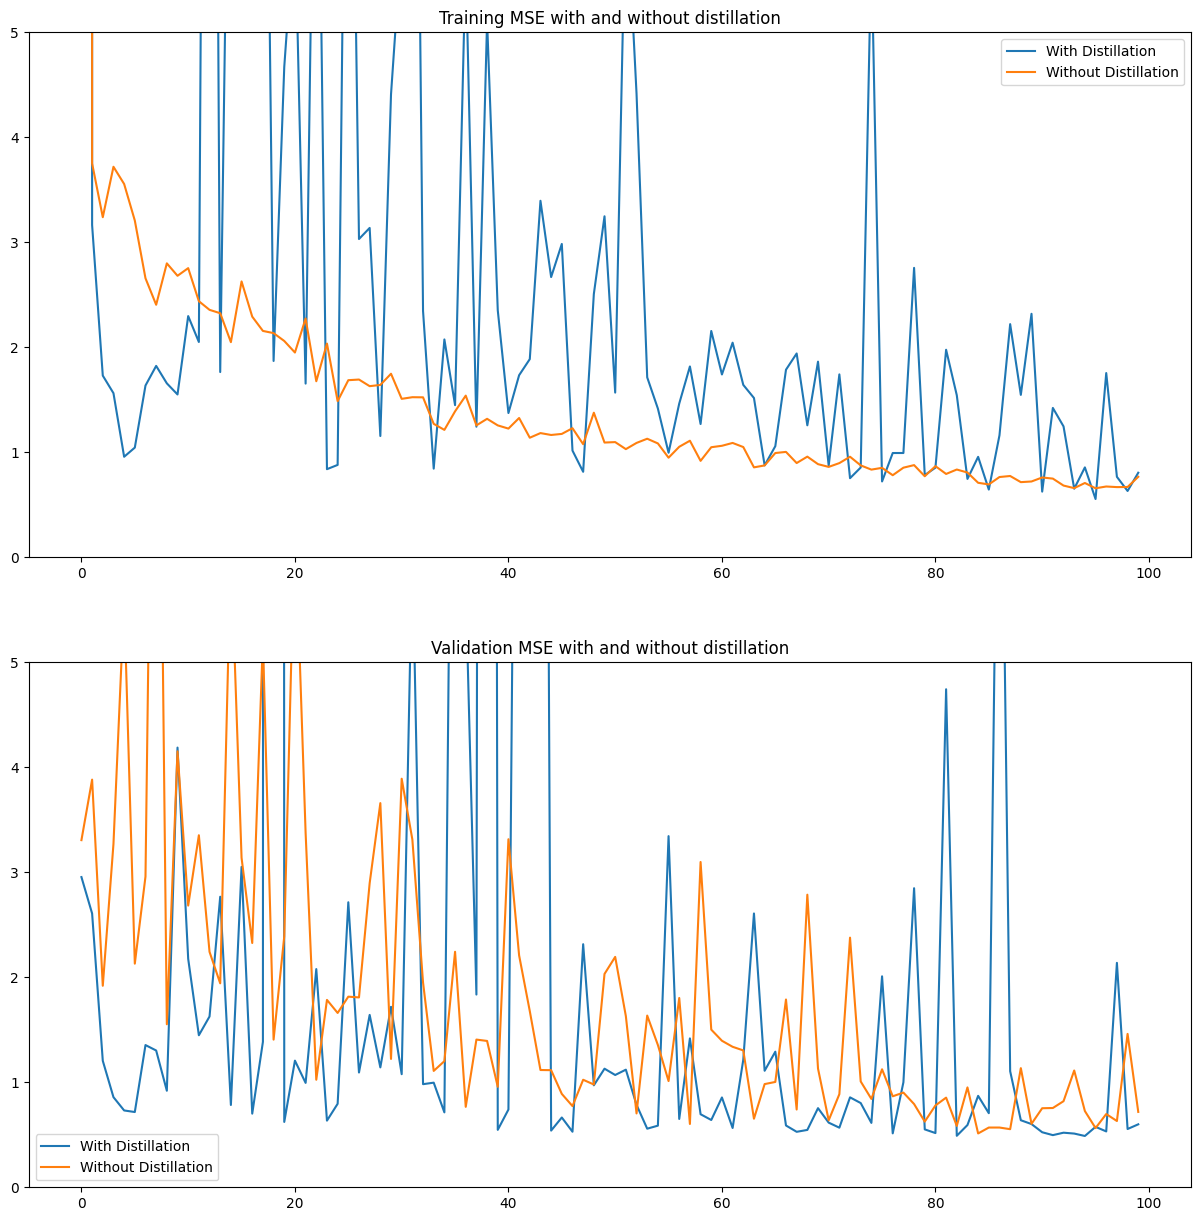

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['mse'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_mse'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_mse'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training MSE with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation MSE with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")
#print(f"Test mse with disstillation {test_results_with_distillation}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")
#print(f"Test mse without disstillation {test_results_without_distillation}")

Validation mse with distillation 0.5969 +- 0.2769
Validation mse without disstillation 0.6161 +- 0.1984


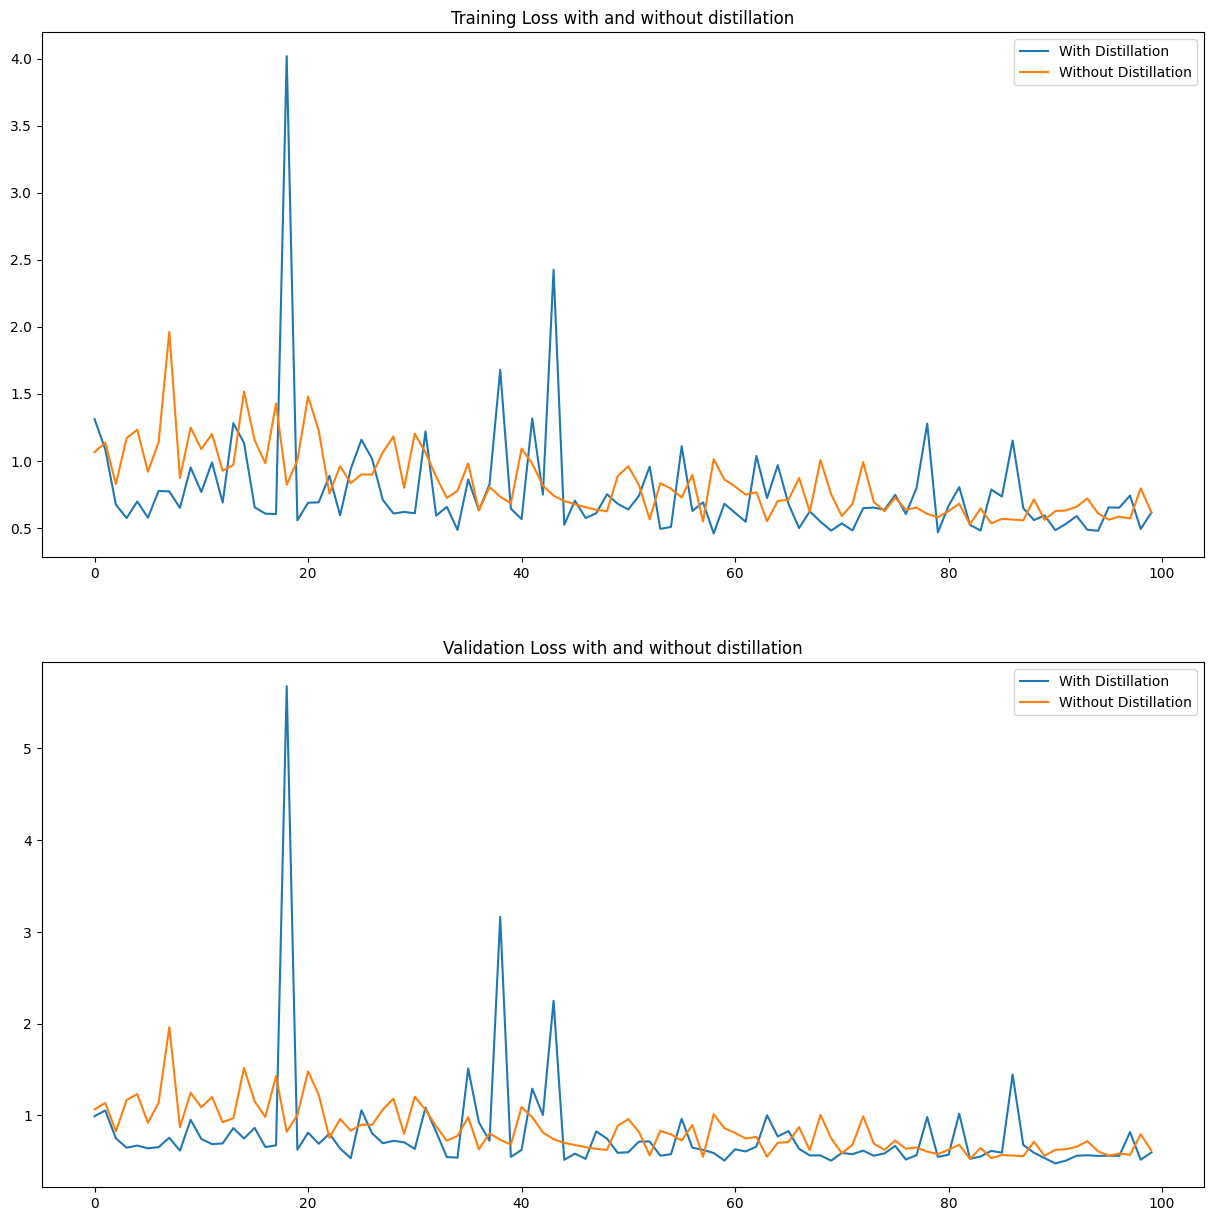

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['student_loss'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['student_loss'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['loss'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_student_loss'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_student_loss'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_loss'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
#axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training Loss with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
#axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation Loss with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")

In [14]:
# Train again on the entire traning set and then test
studnet_model = buildStudentModel()
studnet_model_without_distillation = keras.models.clone_model(studnet_model)

distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['mse', 'mae', 'mape'],
    student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
    distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
    alpha=0.1,
    temperature=10        
)
# Retrain both models
distiller.fit(x_train, y_train, epochs=number_of_epochs)

studnet_model_without_distillation.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['mse', 'mae', 'mape'],
)
studnet_model_without_distillation.fit(x_train, y_train, epochs=number_of_epochs)
    
# Evaluate the models onb the test data when the training is complete    
# Evaluate student on test dataset
test_results_with_distillation = distiller.evaluate(x_test, y_test, return_dict=True)
test_results_without_distillation = studnet_model_without_distillation.evaluate(x_test, y_test, return_dict=True)

Epoch 1/100
492/492 [==============================] - 2s 3ms/step - mse: 2941.3560 - mae: 12.2784 - mape: 828.7272 - student_loss: 12.2414 - distillation_loss: 2931.1838
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - mse: 12.6178 - mae: 1.4664 - mape: 109.6335 - student_loss: 1.4675 - distillation_loss: 12.0279
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - mse: 5.9135 - mae: 1.2452 - mape: 91.4400 - student_loss: 1.2428 - distillation_loss: 5.3587
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - mse: 2.2609 - mae: 0.9815 - mape: 71.0432 - student_loss: 0.9816 - distillation_loss: 1.7680
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - mse: 1.1705 - mae: 0.8133 - mape: 57.6621 - student_loss: 0.8122 - distillation_loss: 0.6943
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - mse: 1.2587 - mae: 0.7951 - mape: 55.0631 - student_loss: 0.7943 - distillation_loss: 0.8087
Epoch 7/100
492/

492/492 [==============================] - 1s 2ms/step - mse: 0.6433 - mae: 0.5978 - mape: 38.5087 - student_loss: 0.5968 - distillation_loss: 0.2230
Epoch 52/100
492/492 [==============================] - 1s 2ms/step - mse: 0.5459 - mae: 0.5616 - mape: 36.1345 - student_loss: 0.5623 - distillation_loss: 0.1280
Epoch 53/100
492/492 [==============================] - 1s 2ms/step - mse: 1.9226 - mae: 0.8999 - mape: 58.4418 - student_loss: 0.8987 - distillation_loss: 1.5206
Epoch 54/100
492/492 [==============================] - 1s 2ms/step - mse: 0.6130 - mae: 0.5831 - mape: 37.5007 - student_loss: 0.5824 - distillation_loss: 0.1911
Epoch 55/100
492/492 [==============================] - 1s 2ms/step - mse: 0.8438 - mae: 0.6605 - mape: 42.8107 - student_loss: 0.6603 - distillation_loss: 0.4349
Epoch 56/100
492/492 [==============================] - 1s 2ms/step - mse: 3.4935 - mae: 0.9062 - mape: 60.1196 - student_loss: 0.9043 - distillation_loss: 3.0818
Epoch 57/100
492/492 [=============

492/492 [==============================] - 1s 2ms/step - loss: 11.2656 - mse: 3041.9331 - mae: 11.2656 - mape: 738.0547
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - loss: 2.4453 - mse: 18.1740 - mae: 2.4453 - mape: 162.8765
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - loss: 2.3984 - mse: 14.0590 - mae: 2.3984 - mape: 159.9643
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - loss: 2.3254 - mse: 14.9265 - mae: 2.3254 - mape: 152.8413
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - loss: 1.9624 - mse: 8.3830 - mae: 1.9624 - mape: 129.6079
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - loss: 1.8704 - mse: 8.3803 - mae: 1.8704 - mape: 124.0198
Epoch 7/100
492/492 [==============================] - 1s 2ms/step - loss: 2.5155 - mse: 14.8299 - mae: 2.5155 - mape: 166.4417
Epoch 8/100
492/492 [==============================] - 1s 2ms/step - loss: 2.7006 - mse: 17.5999 - mae: 2.7006 - m

492/492 [==============================] - 1s 2ms/step - loss: 0.7901 - mse: 1.2783 - mae: 0.7901 - mape: 50.1122
Epoch 66/100
492/492 [==============================] - 1s 2ms/step - loss: 0.8029 - mse: 1.2475 - mae: 0.8029 - mape: 51.2940
Epoch 67/100
492/492 [==============================] - 1s 2ms/step - loss: 0.9257 - mse: 1.9715 - mae: 0.9257 - mape: 59.2598
Epoch 68/100
492/492 [==============================] - 1s 2ms/step - loss: 0.8978 - mse: 1.5970 - mae: 0.8978 - mape: 57.7883
Epoch 69/100
492/492 [==============================] - 1s 2ms/step - loss: 0.8663 - mse: 1.5372 - mae: 0.8663 - mape: 55.3116
Epoch 70/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7567 - mse: 1.1537 - mae: 0.7567 - mape: 47.5139
Epoch 71/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7997 - mse: 1.2530 - mae: 0.7997 - mape: 50.6575
Epoch 72/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7354 - mse: 1.1226 - mae: 0.7354 - mape: 46.31

In [15]:
print(f"Test mse with disstillation {test_results_with_distillation}")
print(f"Test mse without disstillation {test_results_without_distillation}")

Test mse with disstillation {'mse': 0.545138418674469, 'mae': 0.5315641760826111, 'mape': 32.0058479309082, 'student_loss': 0.5572007894515991}
Test mse without disstillation {'loss': 0.6136017441749573, 'mse': 0.7736509442329407, 'mae': 0.6136017441749573, 'mape': 29.835235595703125}


In [22]:
# # Save the model to load in future
# %mkdir Exp1Models
#%mkdir Exp1Models/Exp2

# studnet_model.save('Exp1Models/Exp2/studnet_model')
# studnet_model_without_distillation.save('Exp1Models/Exp2/studnet_model_without_distillation')

The syntax of the command is incorrect.


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets
